In [1]:
prom_file_path = "../r11n14_tb_integrated.parquet"

In [2]:
import numpy as np
from keras.models import Model
from keras.layers import Input, Dense
from keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from keras import regularizers

2023-08-09 16:13:38.305208: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-09 16:13:38.307660: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-09 16:13:38.354302: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-09 16:13:38.355181: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-09 16:13:39.056594: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [5]:
import pandas as pd
prom_df = pd.read_parquet(prom_file_path)

In [7]:
prom_df['successRate'] = prom_df['finishTasks'] / prom_df['jobCount']

In [10]:
prom_df.fillna(0, inplace=True)
feature_cols = [col for col in prom_df.columns if col not in ['node', 'timestamp', 'isAnomaly','node_netstat_Udp_InErrors','node_netstat_Tcp_InErrs','node_netstat_Icmp_InErrors','node_filesystem_device_error-sum','jobID','__index_level_0__']]
X = prom_df[feature_cols]
y = prom_df['isAnomaly']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

input_dim = X.shape[1]  
encoding_dim = 14  
batch_size = 32
epochs = 20

input_layer = Input(shape=(input_dim, ))
encoder = Dense(encoding_dim, activation="tanh", 
                activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)
decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)

autoencoder.compile(optimizer=Adam(), 
                    loss='mean_squared_error', 
                    metrics=['mae'])

history = autoencoder.fit(X_scaled, X_scaled,
                          epochs=epochs,
                          batch_size=batch_size,
                          shuffle=True,
                          validation_data=(X_scaled, X_scaled))

Epoch 1/20
921/921 [==============================] - 5s 5ms/step - loss: 0.6603 - mae: 0.5196 - val_loss: 0.6214 - val_mae: 0.4805
Epoch 2/20
921/921 [==============================] - 4s 5ms/step - loss: 0.6006 - mae: 0.4649 - val_loss: 0.5941 - val_mae: 0.4603
Epoch 3/20
921/921 [==============================] - 3s 4ms/step - loss: 0.5939 - mae: 0.4599 - val_loss: 0.5937 - val_mae: 0.4593
Epoch 4/20
921/921 [==============================] - 4s 4ms/step - loss: 0.5279 - mae: 0.4162 - val_loss: 0.5195 - val_mae: 0.4087
Epoch 5/20
921/921 [==============================] - 4s 5ms/step - loss: 0.5120 - mae: 0.3944 - val_loss: 0.5055 - val_mae: 0.3819
Epoch 6/20
921/921 [==============================] - 4s 5ms/step - loss: 0.5054 - mae: 0.3809 - val_loss: 0.5053 - val_mae: 0.3809
Epoch 7/20
921/921 [==============================] - 4s 4ms/step - loss: 0.5052 - mae: 0.3801 - val_loss: 0.5052 - val_mae: 0.3799
Epoch 8/20
921/921 [==============================] - 4s 4ms/step - loss: 0.

In [11]:
predictions = autoencoder.predict(X_scaled)
mse = np.mean(np.power(X_scaled - predictions, 2), axis=1)

threshold = np.quantile(mse, 0.67)  

y_pred = [1 if e > threshold else 0 for e in mse]

print(classification_report(y, y_pred))
print(confusion_matrix(y, y_pred))

921/921 [==============================] - 2s 2ms/step
              precision    recall  f1-score   support

           0       0.65      0.66      0.65     19625
           1       0.31      0.30      0.30      9826

    accuracy                           0.54     29451
   macro avg       0.48      0.48      0.48     29451
weighted avg       0.54      0.54      0.54     29451

[[12872  6753]
 [ 6860  2966]]


 63/921 [=>............................] - ETA: 0s 

921/921 [==============================] - 2s 2ms/step
              precision    recall  f1-score   support

           0       0.65      0.66      0.65     19625
           1       0.31      0.30      0.30      9826

    accuracy                           0.54     29451
   macro avg       0.48      0.48      0.48     29451
weighted avg       0.54      0.54      0.54     29451

Confusion matrix:
 [[12872  6753]
 [ 6860  2966]]
ROC AUC Score: 0.4788751589763801


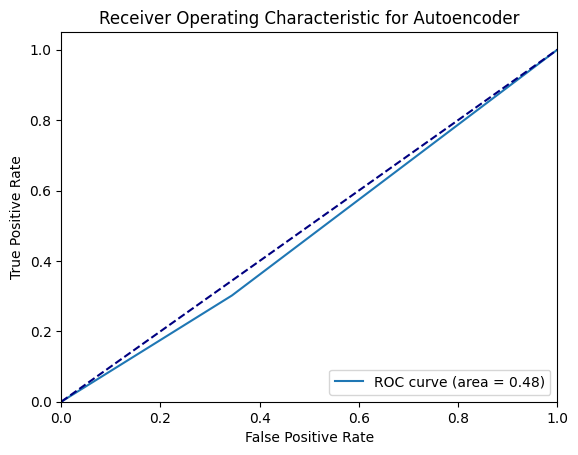

In [12]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import numpy as np

predictions = autoencoder.predict(X_scaled)
mse = np.mean(np.power(X_scaled - predictions, 2), axis=1)
threshold = np.quantile(mse, 0.67)  

y_pred = [1 if e > threshold else 0 for e in mse]
print(classification_report(y, y_pred))

conf_mat = confusion_matrix(y, y_pred)
print('Confusion matrix:\n', conf_mat)

roc_auc = roc_auc_score(y, y_pred)
print('ROC AUC Score:', roc_auc)

fpr, tpr, _ = roc_curve(y, y_pred)
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Autoencoder')
plt.legend(loc="lower right")

plt.savefig('autoencoder_roc_curve_r11n14_integrated.pdf', format='pdf')

plt.show()
